The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,(1280,720),None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../wide_dist_pickle.p", "wb" ) )

In [3]:
# Do camera calibration given object points and image points
def undistort(image):
    f=open("../wide_dist_pickle.p", "rb" )
    dist_pickle=pickle.load(f)
    mtx=dist_pickle['mtx']
    dist=dist_pickle['dist']
    undistort_output = cv2.undistort(image,mtx,dist,None, mtx)
    return undistort_output

In [4]:
##  Part one  apply sobel or color thresholding
def abs_sobel_thresh(img,hls=False,orient='x',sobel_kernel=3,thresh=(20,100)):
    if hls==False:
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    elif hls==True:
        hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
        gray=hls[:,:,1]
    if orient=='x':
        sobel=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient=='y':
        sobel=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel=np.absolute(sobel)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary=np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    return sxbinary
### Define magnitude gradient Function
def mag_thresh(img,sobel_kernel=3,thresh=(0,255)):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,sobel_kernel)
    
    magnitude=np.sqrt(sobelx**2+sobely**2)
    scaled=np.uint8(255*magnitude/np.max(magnitude))
    
    sxbinary=np.zeros_like(scaled)
    sxbinary[(scaled>=thresh[0])&(scaled<=thresh[1])]=1
    
    return sxbinary
##  Define direction of the gradient  
def direction_thresh(img,sobel_kernel=3,thresh=(-np.pi/2,np.pi/2)):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,sobel_kernel)
    abs_x=np.absolute(sobelx)
    abs_y=np.absolute(sobely)
    direction_grad=np.arctan2(abs_y,abs_x)
    
    sxbinary=np.zeros_like(direction_grad)
    sxbinary[(direction_grad>=thresh[0])&(direction_grad<=thresh[1])]=1
    return sxbinary

def hsv_select(img, thresh_low, thresh_high):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    color_binary = np.zeros((img.shape[0], img.shape[1]))
    color_binary[(hsv[:,:,0] >= thresh_low[0]) & (hsv[:,:,0] <= thresh_high[0]) 
                  & (hsv[:,:,1] >= thresh_low[1])  & (hsv[:,:,1] <= thresh_high[1])  
                  & (hsv[:,:,2] >= thresh_low[2]) & (hsv[:,:,2] <= thresh_high[2])] = 1
    return color_binary 

def hls_select(img,thresh=(170,255)):
    if len(img.shape)==3:
        hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s=hls[:,:,2]
    binary=np.zeros_like(s)
    binary[(s>=thresh[0])&(s<=thresh[1])]=1
    return binary

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[800,510],[1150,700],[270,700],[510,510]])
    
    dst = np.float32([[650,470],[640,700],[270,700],[270,510]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    #inverse 
    Minv = cv2.getPerspectiveTransform(dst, src)
    #create a warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    unpersp = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped, unpersp, Minv

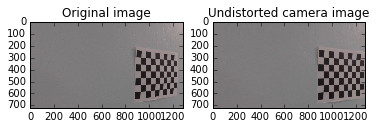

In [5]:
#Distortion corrected camera calibration image
image_origin = '../camera_cal/calibration15.jpg'
img = cv2.imread(image_origin)
undist = undistort(img)

plt.figure(figsize=(1,1))
fig = plt.figure()
a=fig.add_subplot(121)
plt.imshow(img)
a.set_title('Original image')

a=fig.add_subplot(122)
plt.imshow(undist)
a.set_title('Undistorted camera image')

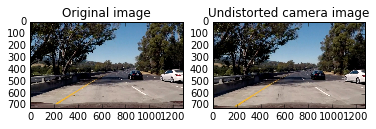

In [6]:
#Distortion corrected testimage
image_origin = '../test_images/test5.jpg'
img = cv2.imread(image_origin)
undist = undistort(img)

plt.figure(figsize=(1,1))
fig = plt.figure()
a=fig.add_subplot(121)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
a.set_title('Original image')

a=fig.add_subplot(122)
plt.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
a.set_title('Undistorted camera image')

In [7]:
# Define a function for creating lane lines
def lane_detector(image, video_mode = False):
    #read image
    if video_mode == False:
        image = cv2.imread(image)
    
    # Undistort image
    undist = undistort(image)
    
    # Apply Gaussian smoothing(kernel size=5)
    undist=cv2.GaussianBlur(undist, (5, 5), 0)

    # Define parameters for gradient thresholding
    sxbinary=abs_sobel_thresh(undist,hls=False,orient='x',sobel_kernel=3,thresh=(22,100))
    mag_binary=mag_thresh(undist,sobel_kernel=3,thresh=(40,100))
    dir_binary=direction_thresh(undist,sobel_kernel=15,thresh=(0.7,1.3))
    
    # Define parameters for color thresholding
    ## s_binary=hls_select(undist,thresh=(90,255))
    s_binary=hls_select(undist,thresh=(150,255))
    
    #Combine various thresholding operations
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary1 = np.zeros_like(sxbinary)
    combined_binary1[(s_binary == 1) | (sxbinary == 1)] = 1
    
    combined_binary2 = np.zeros_like(sxbinary)
    combined_binary2[(s_binary == 1) | (sxbinary == 1)| (mag_binary == 1)] = 1
    
    # Apply perspective transform
    # Define points
    warped_im, _ , Minv = warp(combined_binary1)
    
    return undist, sxbinary, s_binary, combined_binary1, warped_im, Minv

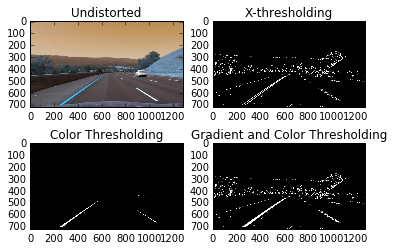

In [8]:
# test image 3 
image= '../test_images/test3.jpg'
orig_img = cv2.imread(image)
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)

#   Plots 
plt.figure(figsize=(10,10))
fig = plt.figure()
a=fig.add_subplot(2,2,1)
plt.imshow(undist)
a.set_title('Undistorted')

a=fig.add_subplot(2,2,2)
plt.imshow(sxbinary, cmap = 'Greys_r')
a.set_title('X-thresholding')

a=fig.add_subplot(2,2,3)
plt.imshow(s_binary, cmap = 'Greys_r')
a.set_title('Color Thresholding')

a=fig.add_subplot(2,2,4)
plt.imshow(combined_binary1, cmap = 'Greys_r')
a.set_title('Gradient and Color Thresholding')

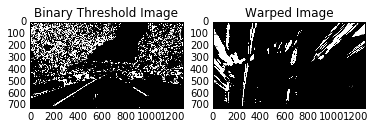

In [9]:
# test image 3  for the warped image
image= '../test_images/test5.jpg'
orig_img = cv2.imread(image)
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)

#Plots 
plt.figure(figsize=(10,10))
fig = plt.figure()
a=fig.add_subplot(121)
plt.imshow(combined_binary1, cmap = 'Greys_r')
a.set_title('Binary Threshold Image')

a=fig.add_subplot(122)
plt.imshow(warped_im, cmap = 'Greys_r')
a.set_title('Warped Image')

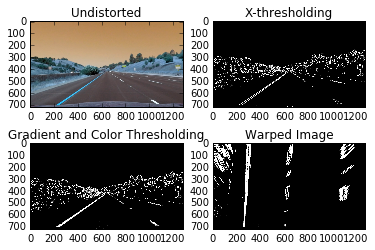

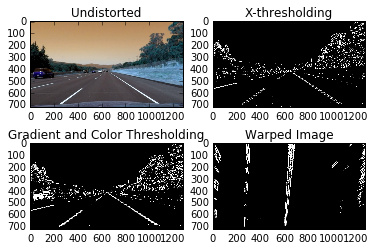

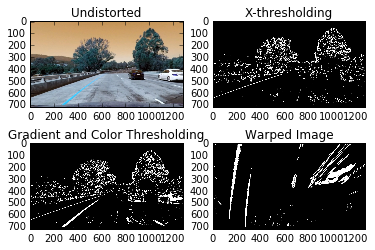

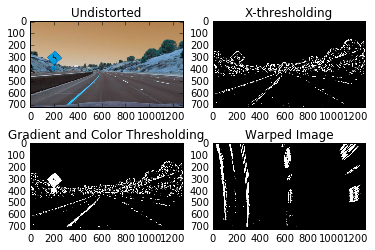

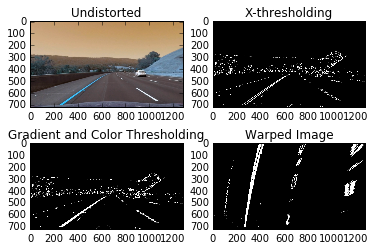

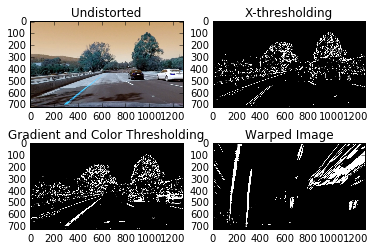

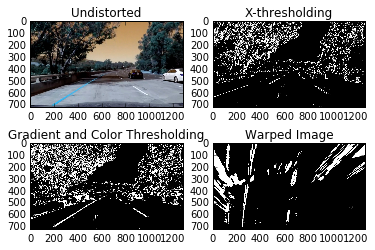

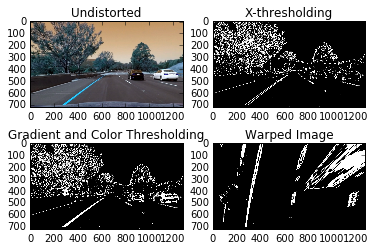

In [10]:
#  Test on test images,then save them to the output_images directory.
import os
images = glob.glob('../test_images/*.jpg')

for index,fname in enumerate(images):
    # Call lane_detector func
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(fname)
    # Save undist image
    outfile =os.path.join('../output_images/','undistort'+str(index)+'.jpg')
    cv2.imwrite(outfile, undist)
    
    #Save gradient thresholding
    sxbinary_output = sxbinary*255
    outfile =os.path.join('../output_images/','sxbinary'+str(index)+'.jpg')
    cv2.imwrite(outfile, sxbinary_output)
    
    # Save S-channel of HLS color thresholding
    hls_binary_output = s_binary*255
    outfile =os.path.join('../output_images/','hls_binary'+str(index)+'.jpg')
    cv2.imwrite(outfile, hls_binary_output)

    # Save Combined thresholding
    combined_binary1_output = combined_binary1*255
    outfile =os.path.join('../output_images/','combined_binary'+str(index)+'.jpg')
    cv2.imwrite(outfile, combined_binary1_output)
    
    # Save gradient thresholding
    warped_im_output = warped_im*255
    outfile =os.path.join('../output_images/','perpective_warped'+str(index)+'.jpg')
    cv2.imwrite(outfile, warped_im_output)
    
    
    #Plots 
    plt.figure(figsize=(10,10))
    fig = plt.figure()
    a=fig.add_subplot(2,2,1)
    plt.imshow(undist)
    a.set_title('Undistorted')

    a=fig.add_subplot(2,2,2)
    plt.imshow(sxbinary, cmap = 'Greys_r')
    a.set_title('X-thresholding')

    a=fig.add_subplot(2,2,3)
    plt.imshow(combined_binary1, cmap = 'Greys_r')
    a.set_title('Gradient and Color Thresholding')

    a=fig.add_subplot(2,2,4)
    plt.imshow(warped_im, cmap = 'Greys_r')
    a.set_title('Warped Image')

In [11]:
## find the lines,draw it and fit a 2nd order polynomial
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def polyfit_warp_image(image,plot=True):
    """ input image is warped image
    """
    binary_warped = image.copy()
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/4)    # the midpoints wo set 1/4 of the X-axis
    leftx_base = np.argmax(histogram[150:midpoint])+150  #we don't search from zero
    rightx_base = np.argmax(histogram[midpoint:midpoint+500]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 70
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if plot == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit,right_fit,out_img

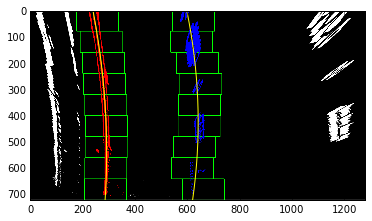

In [12]:
# On test image 3 first
image= '../test_images/test2.jpg'
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)
left_fit, right_fit, out_img = polyfit_warp_image(warped_im)

In [13]:
def fit_continuous(left_fit, right_fit, binary_warped, plot = True):
    #Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    if plot == True:
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit_new, right_fit_new

In [14]:
##  Calculate the lanes' curve
def print_lane_curve(left_fit,right_fit,binary_warped, print_yes= True):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    if print_yes == True:
    #Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center, 'm')
    return left_curverad, right_curverad, center

14374.9655049 m 3493.04892207 m -0.863149846282 m
6130.09987482 m 7282.03525136 m -0.865444787998 m
1054.96398181 m 3700.87206512 m -0.650808356404 m
925.368493179 m 684.224807942 m -1.16583919251 m
1383.18611535 m 1443.88478763 m -0.301465735581 m
14713.1373065 m 666.782931286 m -0.48775793878 m
256.065323727 m 1274.54570205 m -0.557903962051 m
2433.52986805 m 2433.52986805 m -1.21269942733 m


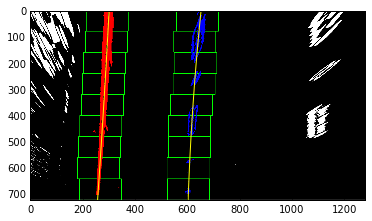

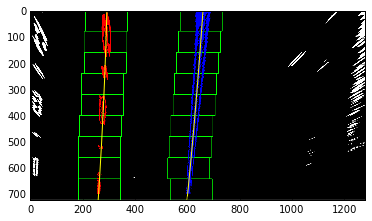

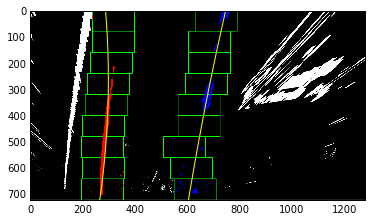

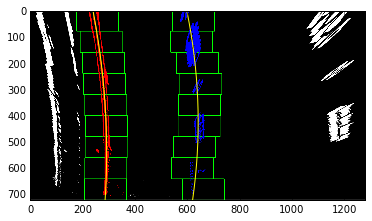

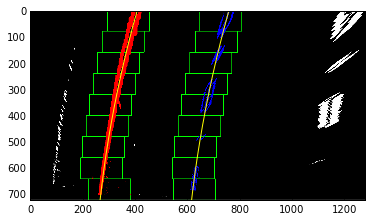

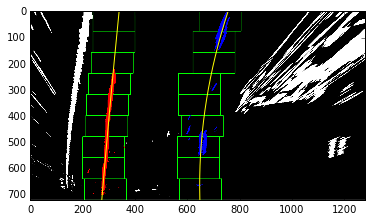

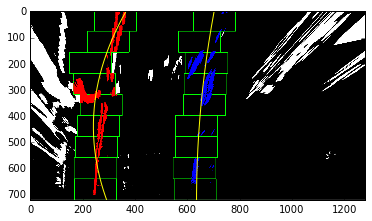

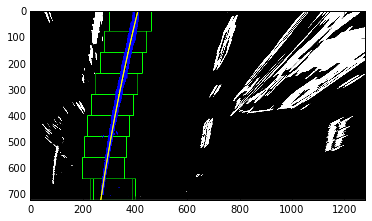

In [15]:
images = glob.glob('../test_images/*.jpg')
for index,fname in enumerate(images):

    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(fname)

    left_fit, right_fit, out_img = polyfit_warp_image(warped_im)
    
    # Save fit_lanes_line image
    outfile =os.path.join('../output_images/','fit_lanes_line'+str(index)+'.jpg')
    cv2.imwrite(outfile, out_img)
    
    print_lane_curve(left_fit, right_fit, out_img)

In [16]:
def add_text_to_image(img, left_cur, right_cur, center):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    cur = (left_cur + right_cur)/2.

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)

    left_or_right = "left" if center < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)

In [17]:
## put the detected lane lines draw back to the origin images
def lane_back_to_origin(undist, warped,left_fit, right_fit, left_cur, right_cur, center, show_img = True ):
    # create an image to draw the lines
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    add_text_to_image(result, left_cur, right_cur, center)
    if show_img == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()
        plt.imshow(result)
    
    return result

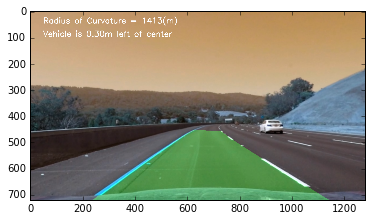

In [18]:
# On test image 3 first
image= '../test_images/test3.jpg'
orig_img = cv2.imread(image)
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)
left_fit, right_fit, out_img = polyfit_warp_image(warped_im, plot= False)

left_cur, right_cur, center = print_lane_curve(left_fit, right_fit, warped_im, print_yes = False)
result  = lane_back_to_origin(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = True)

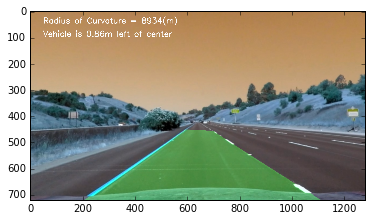

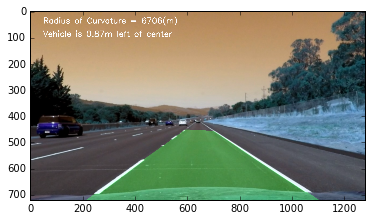

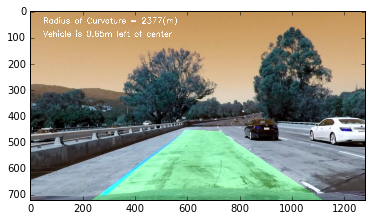

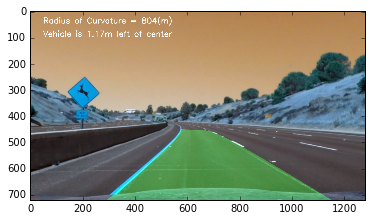

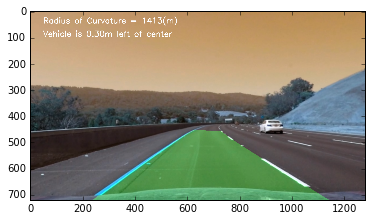

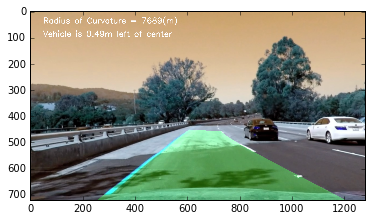

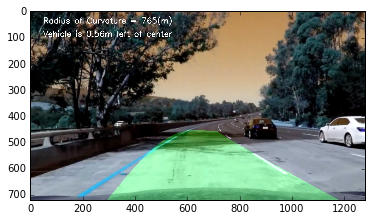

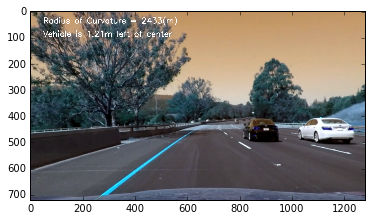

In [19]:
images = glob.glob('../test_images/*.jpg')
for index,fname in enumerate(images):
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(fname)

    left_fit, right_fit, out_img = polyfit_warp_image(warped_im, plot= False)
    left_cur, right_cur, center =print_lane_curve(left_fit, right_fit, warped_im, print_yes = False)
    result  = lane_back_to_origin(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = True)
    
    # Save result image
    outfile =os.path.join('../output_images/','lanes_back_to_origin'+str(index)+'.jpg')
    cv2.imwrite(outfile, result)

In [20]:
def sanity_check(left_fit, right_fit):
    #Performs a sanity check on the lanes

    #1. Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: #apprrox delta in pixels
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        L_0 = 2*left_fit[0]*360+left_fit[1]
        R_0 = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(L_0-R_0)
        
         # Calculate slope of left and right lanes at top of y (i.e. 720)
        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        delta_slope_top =  np.abs(L_1-R_1)
        
        #Check if lines are parallel at the middle
        
        if delta_slope_mid<=0.1:
            status = True
        else:
            status = False
            
    return status

In [21]:
# Pipeline for processing images 
def process_image(image):
    global counter
    global last_left 
    global last_right
    global left_fit
    global right_fit
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image, video_mode = True)
    
    if counter ==0:
        left_fit, right_fit, out_img = polyfit_warp_image(warped_im, plot= False)
    else:
        left_fit, right_fit  = fit_continuous(left_fit, right_fit, warped_im, plot = False)
        
    # Do Sanity check
    status =sanity_check(left_fit, right_fit)
    
    #Decide if to use calculated points
    if status == True:        
        #Save as last reliable fit
        last_left, last_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = last_left, last_right
        
    
    left_cur, right_cur, center = print_lane_curve(left_fit, right_fit, warped_im, print_yes = False)
    
    result = lane_back_to_origin(undist, warped_im, left_fit, right_fit, left_cur, 
                                 right_cur, center, show_img = False)
    
    return result

In [35]:
counter=0
lanes_output = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../project_video.mp4')
lane_clip = clip2.fl_image(process_image)          #NOTE: this function expects color images!!
%time lane_clip.write_videofile(lanes_output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:26<00:00,  4.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

Wall time: 4min 27s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lanes_output))